     
     O código é um exemplo de como implementar um modelo de previsão de séries temporais utilizando redes neurais recorrentes LSTM. A ideia do modelo é utilizarmos os dados históricos da taxa de inadimplência para prever a taxa de inadimplência dos próximos 12 meses. Para isso, realizamos diversas etapas de pré-processamento, tais como normalização dos valores, divisão dos dados em treino e teste, criação de conjuntos de dados para treinamento e teste, e remodelagem dos dados em três tipos de modelos diferentes um LSTM, um de Alisamento Exponencial e um Ensemble - que calcula a média de resultado dos dois anteriores.

     Após a construção do modelo, as previsões são feitas e, em seguida, calculamos o erro médio quadrático (MSE) e o erro médio absoluto (MAE) para avaliar o desempenho do modelos. Quando essas métricas são baixas, significa que o modelo está produzindo previsões precisas e próximas dos valores reais. Isso indica que o modelo está aprendendo padrões importantes na série temporal e é capaz de generalizar bem para novos dados. Portanto, um MSE e MAE baixos são indícios de que um modelo de previsão de séries temporais é robusto e confiável. **Os resultados dos modelos sugerem que a melhor opção de forecast final é o modelo LSTM** capaz de capturar os padrões da série temporal e, portanto, é um modelo adequado para o forecast da taxa de inadimplência. 
     
     Quanto aos principais drivers desses valores, pode-se considerar fatores macroeconômicos, tais como a taxa de juros, a inflação e o desemprego, bem como fatores específicos do setor, como a concessão de crédito, a situação financeira das empresas e o perfil dos consumidores.

##### Importar Libs

In [158]:
# Importar Libs

import requests
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

##### Load Data

In [159]:
# Carregar dados
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.21082/dados?formato=json"
response = requests.get(url)
data = json.loads(response.text)

In [160]:
# Preparar dados
df = pd.DataFrame(data)
df['data'] = pd.to_datetime(df['data'], dayfirst=True)
df['valor'] = df['valor'].astype(float)
df.set_index('data', inplace=True)

In [161]:
# Normalizar dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Dividir dados em treino e teste
train_size = int(len(scaled_data) * 0.9)
train, test = scaled_data[:train_size], scaled_data[train_size:]

##### Split Data

In [162]:
# Função para criar conjuntos de dados para treinamento e teste
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Criar conjuntos de dados para treinamento e teste
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)


In [163]:
# Remodelar a entrada para ser [amostras, etapas de tempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

##### Train Model

###### Neural LSTM

In [164]:
# Criar e treinar a rede LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
128/128 - 4s - loss: 0.1813 - 4s/epoch - 30ms/step
Epoch 2/100
128/128 - 0s - loss: 0.0475 - 282ms/epoch - 2ms/step
Epoch 3/100
128/128 - 0s - loss: 0.0228 - 275ms/epoch - 2ms/step
Epoch 4/100
128/128 - 0s - loss: 0.0191 - 328ms/epoch - 3ms/step
Epoch 5/100
128/128 - 0s - loss: 0.0165 - 466ms/epoch - 4ms/step
Epoch 6/100
128/128 - 0s - loss: 0.0139 - 367ms/epoch - 3ms/step
Epoch 7/100
128/128 - 0s - loss: 0.0115 - 342ms/epoch - 3ms/step
Epoch 8/100
128/128 - 0s - loss: 0.0095 - 475ms/epoch - 4ms/step
Epoch 9/100
128/128 - 0s - loss: 0.0076 - 318ms/epoch - 2ms/step
Epoch 10/100
128/128 - 0s - loss: 0.0063 - 264ms/epoch - 2ms/step
Epoch 11/100
128/128 - 0s - loss: 0.0052 - 326ms/epoch - 3ms/step
Epoch 12/100
128/128 - 0s - loss: 0.0043 - 382ms/epoch - 3ms/step
Epoch 13/100
128/128 - 0s - loss: 0.0037 - 329ms/epoch - 3ms/step
Epoch 14/100
128/128 - 0s - loss: 0.0033 - 334ms/epoch - 3ms/step
Epoch 15/100
128/128 - 0s - loss: 0.0031 - 384ms/epoch - 3ms/step
Epoch 16/100
128/128 

In [165]:
# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverter previsões
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

1/1 [==============================] - 1s 655ms/step


In [166]:
# Exibir previsões para os próximos 12 meses (LSTM)
print("Previsões para os próximos 12 meses (LSTM):")
for i, prediction in enumerate(test_predict[:12, 0]):
    print(f"Mês {i + 1}: {prediction:.2f}")


Previsões para os próximos 12 meses (LSTM):
Mês 1: 2.29
Mês 2: 2.44
Mês 3: 2.49
Mês 4: 2.58
Mês 5: 2.64
Mês 6: 2.71
Mês 7: 2.64
Mês 8: 2.76
Mês 9: 2.81
Mês 10: 2.83
Mês 11: 2.96
Mês 12: 3.00


###### Alisamento Exponencial

In [167]:
# Alisamento Exponencial
hw_model = ExponentialSmoothing(df.iloc[:train_size, 0], seasonal_periods=12, trend='add', seasonal='multiplicative').fit()
hw_pred = hw_model.forecast(12)

# Prever os próximos 12 meses usando LSTM e Alisamento Exponencial
future_steps = 12
last_train_value = train[-1]
predictions = []

for i in range(future_steps):
    x_input = np.array([last_train_value]).reshape((1, 1, 1))
    lstm_pred = model.predict(x_input)
    last_train_value = lstm_pred
    lstm_pred = scaler.inverse_transform(lstm_pred)
    hw_pred_i = hw_pred[i] if i < len(hw_pred) else hw_pred[-1]
    ensemble_pred = (lstm_pred[0][0] + hw_pred_i) / 2
    predictions.append(ensemble_pred)

c:\Users\MateusDeNadaiLofrano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


1/1 [==============================] - 0s 54ms/step


In [168]:
# Exibir previsões para os próximos 12 meses (Alisamento Exponencial)
print("Previsões para os próximos 12 meses (Alisamento Exponencial):")
for i, prediction in enumerate(hw_pred):
    print(f"Mês {i + 1}: {prediction:.2f}")

Previsões para os próximos 12 meses (Alisamento Exponencial):
Mês 1: 2.25
Mês 2: 2.31
Mês 3: 2.35
Mês 4: 2.37
Mês 5: 2.44
Mês 6: 2.49
Mês 7: 2.38
Mês 8: 2.41
Mês 9: 2.43
Mês 10: 2.43
Mês 11: 2.47
Mês 12: 2.45


###### Ensemble

In [169]:
# Exibir previsões para os próximos 12 meses
print("Previsões para os próximos 12 meses (LSTM + Alisamento Exponencial):")
for i, prediction in enumerate(predictions):
    print(f"Mes {i + 1}: {prediction:.2f}")

Previsões para os próximos 12 meses (LSTM + Alisamento Exponencial):
Mes 1: 2.28
Mes 2: 2.30
Mes 3: 2.32
Mes 4: 2.32
Mes 5: 2.36
Mes 6: 2.38
Mes 7: 2.32
Mes 8: 2.33
Mes 9: 2.34
Mes 10: 2.34
Mes 11: 2.36
Mes 12: 2.35


##### Avaliação do Forecast

	 Abaixo calculamos as métricas de erro dos modelos. No caso de séries temporais utilizamos o cálculo do MSE, ou erro médio quadrático, e MAE, ou erro médio absoluto.

In [170]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular o erro para o modelo LSTM
mse_lstm = mean_squared_error(Y_test[0], test_predict[:,0])
mae_lstm = mean_absolute_error(Y_test[0], test_predict[:,0])

# Calcular o erro para o modelo de Alisamento Exponencial
mse_hw = mean_squared_error(df.iloc[train_size:train_size + 12, 0], hw_pred)
mae_hw = mean_absolute_error(df.iloc[train_size:train_size + 12, 0], hw_pred)

# Calcular o erro para o ensemble (LSTM + Alisamento Exponencial)
ensemble_pred = np.array([(test_predict[i, 0] + hw_pred[i]) / 2 for i in range(len(hw_pred))])
mse_ensemble = mean_squared_error(df.iloc[train_size:train_size + 12, 0], ensemble_pred)
mae_ensemble = mean_absolute_error(df.iloc[train_size:train_size + 12, 0], ensemble_pred)


In [171]:
# Imprimir os erros para os três modelos
print(f"MSE - LSTM: {mse_lstm:.4f}, Alisamento Exponencial: {mse_hw:.4f}, Ensemble (LSTM + Alisamento Exponencial): {mse_ensemble:.4f}")
print(f"MAE - LSTM: {mae_lstm:.4f}, Alisamento Exponencial: {mae_hw:.4f}, Ensemble (LSTM + Alisamento Exponencial): {mae_ensemble:.4f}")

MSE - LSTM: 0.0112, Alisamento Exponencial: 0.1102, Ensemble (LSTM + Alisamento Exponencial): 0.0300
MAE - LSTM: 0.0942, Alisamento Exponencial: 0.2980, Ensemble (LSTM + Alisamento Exponencial): 0.1568



     Um MSE menor indica um melhor ajuste do modelo. Neste caso, no modelo que obteve o menor resultado foi o LSTM . Da mesma maneira, um MAE menor também indica uma boa aderência do modelo, ou seja que em média nossas previsões estão desviando o valor de *MAE - LSTM* em relação aos valores reais. Realizado o cálculo das métricas pode-se considerar que o modelo com melhor resultado foi o de LSTM, sendo assim considerado nosso forecast final.

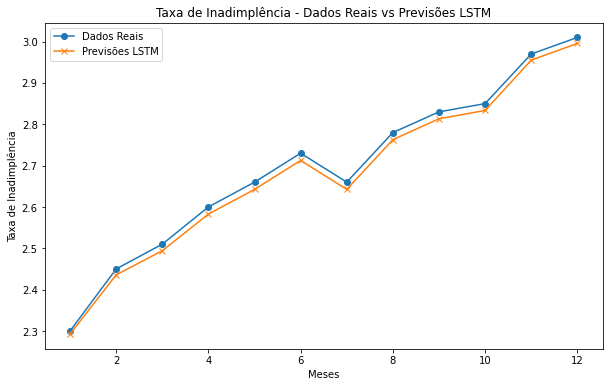

In [172]:
# Preparar os dados para o gráfico
lstm_predictions = test_predict[:12, 0]

# Criar o gráfico
x_labels = np.arange(1, 13, 1)

real_data = df.iloc[train_size:train_size + 12, 0]

plt.figure(figsize=(10, 6))
plt.plot(x_labels, real_data, label="Dados Reais", marker='o')
plt.plot(x_labels, lstm_predictions, label="Previsões LSTM", marker='x')
plt.xlabel("Meses")
plt.ylabel("Taxa de Inadimplência")
plt.title("Taxa de Inadimplência - Dados Reais vs Previsões LSTM")
plt.legend()
plt.show()